In [1]:
import json
import pathlib
import pycolmap
import datetime
import random

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler, DataLoader, random_split

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pyvista as pv

import neural_orientation_field.utils as utils
import neural_orientation_field.colmap.colmap_utils as colutils
from neural_orientation_field.nerf.dataset import NeRFImageDataset, NeRFRayDataset
from neural_orientation_field.nerf.model import NeRfCoarseModel, NeRfFineModel
from neural_orientation_field.nerf.utils import pos_encode, static_volumetric_renderer, adaptive_volumetric_renderer

In [2]:
# Seed rng for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Load Dataset

In [3]:
# Neural Orientation Field config
IMAGE_PATH = "../data/images/hoover-tower-low-res/"
COLMAP_MODEL_PATH = "../data/output/colmap/model/0/"

image_dir = pathlib.Path(IMAGE_PATH).resolve()
colmap_model_path = pathlib.Path(COLMAP_MODEL_PATH).resolve()

image_dir, colmap_model_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/hoover-tower-low-res'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/output/colmap/model/0'))

In [4]:
image_dataset = NeRFImageDataset(image_dir, colmap_model_path)
num_train = int(0.9 * len(image_dataset))
num_test = len(image_dataset) - num_train
image_dataset_train, image_dataset_test = random_split(image_dataset, [num_train, num_test])
len(image_dataset_train), len(image_dataset_test)

(226, 26)

In [5]:
with tqdm(total=len(image_dataset_train), desc="Processing Image") as progress:
    ray_dataset = NeRFRayDataset(image_dataset_train, progress)

Processing Image:   0%|          | 0/226 [00:00<?, ?it/s]

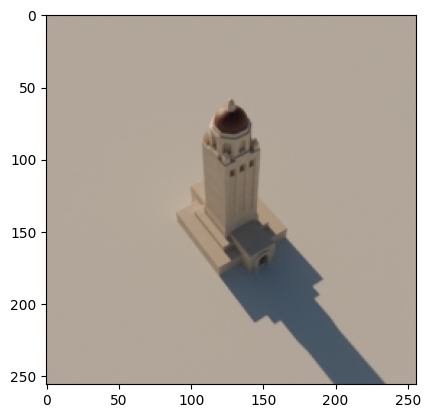

In [6]:
idx = 0
image, _, _, _, _, _ = image_dataset_test[idx]
plt.imshow(image)

# NeRF

In [7]:
# Use MPS device.
USE_DEVICE = "mps"

if USE_DEVICE == "mps" and torch.mps.is_available():
    device = torch.device("mps")
elif USE_DEVICE == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# NeRF Training

In [8]:
# Near/far clipping distance.
nc = 1
fc = 8
# Positional encoding number.
coarse_pos_encode = 2
fine_pos_encode = 4
samples_per_ray = 8
max_subd_samples = 4
# Hyper parameters.
lr = 4e-5
num_iters = 8
ray_batch_size = 4096
# Training settings.
size_train_ray = 1
save_image_every_n_batch = 512

# Init model.
coarse_model = NeRfCoarseModel(num_encoding_functions=coarse_pos_encode)
coarse_model.to(device)
optimizer = torch.optim.Adam(coarse_model.parameters(), lr=lr)

fine_model = NeRfFineModel(num_encoding_functions=fine_pos_encode)
fine_model.to(device)
optimizer = torch.optim.Adam(fine_model.parameters(), lr=lr)

In [9]:
# Show volumetric rendering.
def render_nerf_eval(model, num_pos_encode, cam_orig_eval, cam_ray_eval):
    cam_orig_eval = torch.from_numpy(cam_orig_eval).type(torch.float32).to(device)
    cam_orig_eval = cam_orig_eval.view(1, 1, -1)
    cam_orig_eval = cam_orig_eval.expand(image_eval.shape)
    cam_ray_eval = torch.from_numpy(cam_ray_eval).type(torch.float32).to(device)
    cam_orig_eval = cam_orig_eval.reshape(-1, 3)
    cam_ray_eval = cam_ray_eval.reshape(-1, 3)
    num_pixels = cam_orig_eval.shape[0]
    color_pred = torch.zeros((num_pixels, 3))
    for i in range(0, num_pixels, ray_batch_size):
        color_batch, _, _ = static_volumetric_renderer(
            model,
            cam_orig_eval[i:i+ray_batch_size],
            cam_ray_eval[i:i+ray_batch_size],
            nc,
            fc,
            num_sample=samples_per_ray*max_subd_samples,
            num_pos_encode=num_pos_encode,
            device=device
        )
        color_pred[i:i+ray_batch_size] = color_batch.detach()
    image_pred = color_pred.reshape(image_eval.shape)
    return image_pred

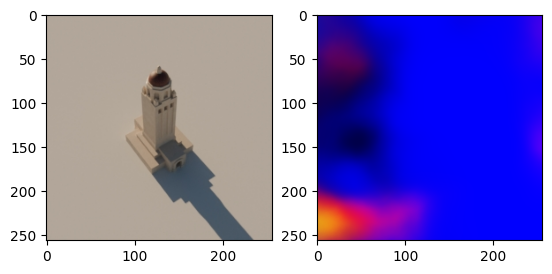

In [10]:
# Test coarse model.
image_eval, _, _, _, cam_orig_eval, cam_ray_eval = image_dataset_test[0]
coarse_model.eval()
image_pred = render_nerf_eval(coarse_model, coarse_pos_encode, cam_orig_eval, cam_ray_eval)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval)
ax_pred.imshow(image_pred.detach().cpu())

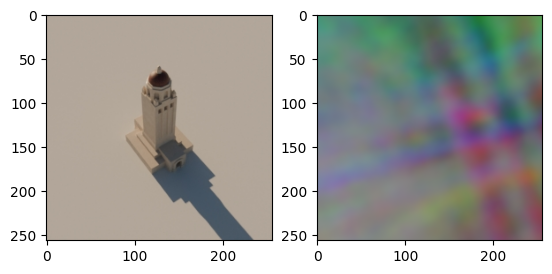

In [11]:
# Test fine model.
image_eval, _, _, _, cam_orig_eval, cam_ray_eval = image_dataset_test[0]
fine_model.eval()
image_pred = render_nerf_eval(fine_model, fine_pos_encode, cam_orig_eval, cam_ray_eval)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval)
ax_pred.imshow(image_pred.detach().cpu())

In [ ]:
coarse_model.train()
fine_model.train()

train_sampler = RandomSampler(data_source=ray_dataset, num_samples=int(size_train_ray * len(ray_dataset)))
dataloader = DataLoader(
    ray_dataset,
    sampler=train_sampler,
    batch_size=ray_batch_size,
)

writer = SummaryWriter(flush_secs=1)
for it in tqdm(range(num_iters)):
    # One iteration of the training.
    for batch_i, (cam_orig_batch, cam_ray_batch, color_batch) in enumerate(tqdm(dataloader)):
        cam_orig_batch = cam_orig_batch.type(torch.float32).to(device)
        cam_ray_batch = cam_ray_batch.type(torch.float32).to(device)
        color_batch = color_batch.type(torch.float32).to(device)
        coarse_color_pred, occupancy, sample_depth = static_volumetric_renderer(
            coarse_model,
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            nc,
            fc,
            num_sample=samples_per_ray,
            num_pos_encode=coarse_pos_encode,
            device=device
        )
        loss_coarse = torch.nn.functional.mse_loss(coarse_color_pred, color_batch)
        loss_coarse.backward()
        # fine_color_pred, _, _ = adaptive_volumetric_renderer(
        #     fine_model,
        #     cam_orig_batch.reshape(-1, 3),
        #     cam_ray_batch.reshape(-1, 3),
        #     occupancy,
        #     sample_depth,
        #     max_subd_sample=max_subd_samples,
        #     num_pos_encode=fine_pos_encode,
        #     device=device
        # )
        # loss_fine = torch.nn.functional.mse_loss(fine_color_pred, color_batch)
        # loss_fine.backward()
        optimizer.step()
        optimizer.zero_grad()
        writer.add_scalar("Coarse Loss", loss_coarse, (it * len(dataloader) + batch_i) * ray_batch_size)
        # writer.add_scalar("Fine Loss", loss_fine, (it * len(dataloader) + batch_i) * ray_batch_size)
        if batch_i % save_image_every_n_batch == 0:
            coarse_model.eval()
            fine_model.eval()
            _, _, _, _, cam_orig_eval, cam_ray_eval = image_dataset_test[0]
            coarse_image_pred = render_nerf_eval(coarse_model, coarse_pos_encode, cam_orig_eval, cam_ray_eval)
            writer.add_image("Test Image with Coarse Model", coarse_image_pred, (it * len(dataloader) + batch_i) * ray_batch_size, dataformats="HWC")
            fine_image_pred = render_nerf_eval(fine_model, fine_pos_encode, cam_orig_eval, cam_ray_eval)
            writer.add_image("Test Image with Fine Model", fine_image_pred, (it * len(dataloader) + batch_i) * ray_batch_size, dataformats="HWC")
            coarse_model.train()
            fine_model.train()
writer.close()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3616 [00:00<?, ?it/s]

In [ ]:
image_eval, _, _, _, cam_orig_eval, cam_ray_eval = image_dataset_test[0]
fine_model.eval()
image_pred = render_nerf_eval(fine_model, fine_pos_encode, cam_orig_eval, cam_ray_eval)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval)
ax_pred.imshow(image_pred.detach().cpu())